In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

def generate_guesses(x):
    guesses = []
    for i in x:
        if np.abs(i) < 1e-15:
            guesses.append(np.array([1e-15]))
        else:
            guesses.append(np.linspace(i - 0.4, i + 0.1, 3))
    return np.concatenate(guesses)

def calculate_pde_eigenvalues(m0, m1, m2):
    return np.sqrt(((np.pi * m0)**2 + (np.pi * m1)**2 + (np.pi * m2)**2) / 3)

ms = [[1, 1, 1], [2, 1, 1], [2, 2, 1]]

powers_of_10_lims = (2, 4)
num_Vs_per_tile = 1
num_graphs_per_power_of_10 = 5
total_dpowers = num_graphs_per_power_of_10 * (powers_of_10_lims[1] - powers_of_10_lims[0]) + 1
power_linspace = np.linspace(powers_of_10_lims[0], powers_of_10_lims[1], total_dpowers)

tiles_per_dim = np.int32((10**power_linspace / num_Vs_per_tile)**(1 / 3))

In [2]:
class Stacked_Lattice(Graph, Flat):

    def __init__(self, num_xy_translations, autoplot=True, figsize=10, embedding_space=None, **kwargs):

        self.num_xy_translations = num_xy_translations
        self.V_coords, self.E_lengths_by_v_num, self.interior_V_num = self.construct_V_coords()
        self.num_Vs = self.V_coords.shape[0]
        self.wadjacency_matrix = self.construct_wadjacency_matrix()
        self.g_coords = self.construct_g_coords()

        if autoplot:
            print(f"\n|V| = {self.num_Vs}")
            self.plot_graph(figsize=figsize, dim=3, embedding_space=embedding_space)

    def construct_V_coords(self):

        tol = 10

        temp_g = construct_graph.tiling.Tiling(tile_type='square_tile',
                                          num_horizontal_displacements=self.num_xy_translations,
                                          num_vertical_displacements=self.num_xy_translations,
                                          autoplot=False, rescale=True, periodic=False)
        
        stacked_V_coords = temp_g.V_coords.copy()
        e_length = list(temp_g.E_lengths_by_v_num.values())[0]
        z_values = [j * e_length for j in range(int(1 / e_length) + 1)]
        xy_num_Vs = stacked_V_coords.shape[0]
        stacked_V_coords = np.vstack(([np.hstack((stacked_V_coords, np.repeat(z_value, xy_num_Vs)[:, None])) for z_value in z_values]))

        kdtree = scipy.spatial.cKDTree(stacked_V_coords)
        vertices_within_distance = [kdtree.query_ball_point(vertex, e_length + 10**(-tol)) for vertex in stacked_V_coords]
        for en, v in enumerate(vertices_within_distance):
            vertices_within_distance[en] = [i for i in v if i != en]

        E_lengths_by_v_num = {}

        for v_num, w_nums in enumerate(vertices_within_distance):
            for w_num in w_nums:
                if v_num < w_num:
                    E_lengths_by_v_num[v_num, w_num] = np.linalg.norm(stacked_V_coords[v_num] - stacked_V_coords[w_num])

        min_x_mask = stacked_V_coords[:, 0] < 1e-10
        min_y_mask = stacked_V_coords[:, 1] < 1e-10
        min_z_mask = stacked_V_coords[:, 2] < 1e-10

        max_x_mask = stacked_V_coords[:, 0] > 1 - 1e-10
        max_y_mask = stacked_V_coords[:, 1] > 1 - 1e-10
        max_z_mask = stacked_V_coords[:, 2] > 1 - 1e-10

        boundary_mask = min_x_mask | min_y_mask | min_z_mask | max_x_mask | max_y_mask | max_z_mask
        interior_mask = np.argwhere(~boundary_mask).flatten()

        return stacked_V_coords, E_lengths_by_v_num, interior_mask

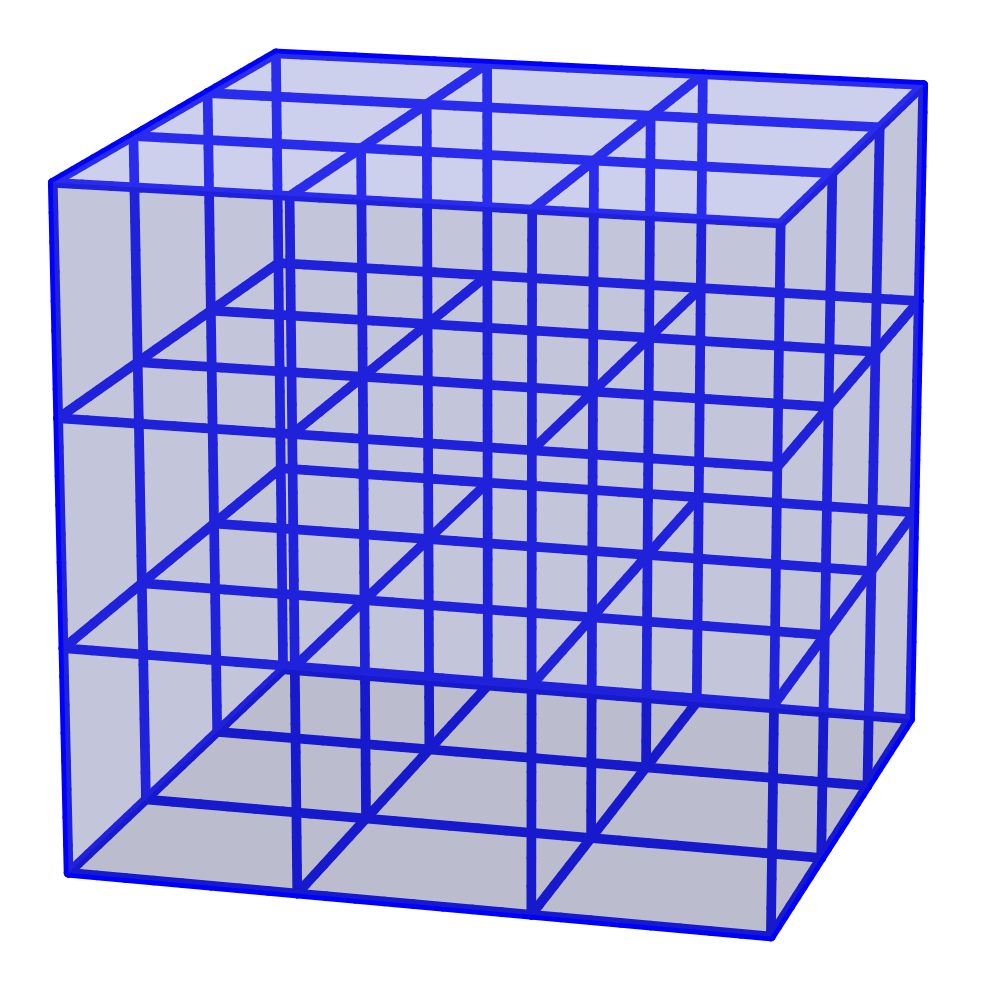

In [193]:
g = Stacked_Lattice(tiles_per_dim[0], autoplot=False)
fig, ax = g.plot_graph(dim=3, return_figax=True)
axes = [1, 1, 1]
data = np.ones(axes) == 1
ax.voxels(data, facecolors='xkcd:periwinkle blue', alpha=0.2, zorder=10)
fac=0.1
ax.set_xlim(fac, 1-fac)
ax.set_ylim(fac, 1-fac)
ax.set_zlim(fac*0.8, 1-fac*1.2)
plt.savefig("tiling/cubic_clamped/small_cubic_clamped.png", dpi=200, bbox_inches="tight")
# plt.show()

In [3]:
run_eigenvalue_calculations = False

In [4]:
if run_eigenvalue_calculations:
    guesses = np.concatenate([np.linspace(3, 5.5, 30)])

    eigenvalue_data = {}

    for tile_num in tiles_per_dim:
        g = Stacked_Lattice(tile_num, autoplot=False)
        print(f"num_Vs = {g.num_Vs}")
        print("\n\n\n")
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        ks = eigs(guesses, printerval=np.inf, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
        _, index = np.unique(np.round(ks, 6), return_index=True)
        eigenvalues = ks[index]
        eigenvalue_data[g.num_Vs] = eigenvalues.copy()

run_eigenvalue_calculations = False

In [5]:
class Projector:

    def __init__(self, g, eigenvalues, continuum_eigendata):

        self.data = {}
        self.modes = solve_laplace_operator.solve_laplace_operator.Graph_Modes(g, eigenvalues)
        self.V_coords = g.V_coords
        self.g_coords = g.g_coords
        self.continuum_eigendata = continuum_eigendata

    def construct_pde_functions(self, ms, function_domain="vertices"):

        basis_functions = self.continuum_eigendata.generate_basis_functions(ms)
        dim = self.V_coords.shape[-1]

        if function_domain == "vertices":
            coords = [self.V_coords[:, i] for i in range(dim)]
            pde_eigenvectors = [function(*coords) for function in basis_functions]
            pde_eigenvectors = [function / np.linalg.norm(function) for function in pde_eigenvectors]
            pde_eigenvectors = np.vstack((pde_eigenvectors)).T

            return pde_eigenvectors
        
        elif function_domain == "graph":
            pde_eigenfunctions = [[] for _ in range(len(basis_functions))]

            for edge in self.g_coords:
                edge_coords = [edge[i] for i in range(dim)]
                
                for i in range(len(basis_functions)):
                    pde_eigenfunctions[i].append(basis_functions[i](*edge_coords))

            pde_eigenfunctions = [solve_laplace_operator.solve_laplace_operator.Graph_Function(pde_eigenfunction, self.g_coords).normalize() 
                                  for pde_eigenfunction in pde_eigenfunctions]
            
            return pde_eigenfunctions

        elif function_domain == "continuum":
            edge = np.linspace(0, 1, 256, endpoint=True)   
            coords = [np.meshgrid(edge, edge) for _ in range(dim)]
            pde_eigenfunctions = [function(*coords) for function in basis_functions]

            return coords, pde_eigenfunctions

    def find_graph_eigenspace(self, ms):

        pde_eigenvectors = self.construct_pde_functions(ms, function_domain="vertices")
        num_basis_functions = pde_eigenvectors.shape[1]
        prod = pde_eigenvectors.T @ pde_eigenvectors
        invert_prod = np.linalg.inv(prod)
        proj = (pde_eigenvectors @ invert_prod @ pde_eigenvectors.T)

        keep_args = proj @ self.modes.graph_eigenvectors
        keep_args = np.argsort(np.linalg.norm(keep_args, axis=0))[-num_basis_functions:]

        # Handle when the graph eigenspace is larger than the PDE eigenspace
        uniques, counts = np.unique(np.round(self.modes.graph_eigenvalues[keep_args], 10), return_counts=True)
        new_keep_args = []
        for unique, count in zip(uniques, counts):
            where_equal = np.where(np.abs(self.modes.graph_eigenvalues - unique) < 1e-9)[0]
            if np.shape(where_equal)[0] != count:
                message = (f"For num_Vs={self.V_coords.shape[0]},ms={ms}, the graph eigenspace is larger than the PDE eigenspace. " + 
                            "This might be (a) a problem, (b) saying something interesting, or (c) nothing special.")
                warnings.warn(message)
            new_keep_args.append(where_equal)
        keep_args = np.concatenate((new_keep_args))

        return keep_args

    def __call__(self, ms):

        self.data[ms] = {"graph": {}, "PDE": {}}

        # Get PDE eigenvalues
        self.data[ms]["PDE"]["eigenvalue"] = self.continuum_eigendata.calculate_pde_eigenvalues(ms).flatten()

        # Get PDE eigenfunctions
        pde_eigenfunctions = self.construct_pde_functions(ms, function_domain="graph")
        self.data[ms]["PDE"]["eigenfunction"] = pde_eigenfunctions
        
        # Get graph eigenvalues
        keep_args = self.find_graph_eigenspace(ms)
        self.data[ms]["graph"]["eigenvalue"] = self.modes.graph_eigenvalues[keep_args]

        # Get graph eigenfunctions
        project_functions = []
        for pde_eigenfunction in pde_eigenfunctions:
            projection = []
            for arg in keep_args:
                ip = pde_eigenfunction.dot(self.modes.graph_eigenfunctions[arg])
                projection.append(ip * self.modes.graph_eigenfunctions[arg])
            project_functions.append(np.sum(projection))
        self.data[ms]["graph"]["eigenfunction"] = project_functions 

class Continuum_Eigendata:

    def __init__(self, problem):

        self.problem = problem

    def calculate_pde_eigenvalues(self, ms):

        if self.problem == "clamped_square_cube":
            func_pde_eigenvalues = lambda m0, m1, m2: np.sqrt(((np.pi * m0)**2 + 
                                                               (np.pi * m1)**2 + 
                                                               (np.pi * m2)**2) / 3)
            if np.isscalar(ms[0]): m0 = np.array([ms[0]])
            else: m0 = ms[0]
            if np.isscalar(ms[1]): m1 = np.array([ms[1]])
            else: m1 = ms[1]
            if np.isscalar(ms[2]): m2 = np.array([ms[2]])
            else: m2 = ms[2]
            pde_eigenvalues = np.zeros((len(m0), len(m1), len(m2)))
            for en0, em0 in enumerate(m0):
                for en1, em1 in enumerate(m1):
                    for en2, em2 in enumerate(m2):
                        pde_eigenvalues[en0, en1, en2] = func_pde_eigenvalues(em0, em1, em2)

            return pde_eigenvalues

    def generate_basis_functions(self, ms):

        if self.problem == "clamped_square_cube":

            if (np.any(ms) < 1) or (np.any(ms) > 2):
                raise ValueError("Projector is only set up for m, n \in [1, 2]")

            sss = lambda m0, m1, m2: lambda x, y, z: (np.sin(np.pi * m0 * x) * 
                                                      np.sin(np.pi * m1 * y) * 
                                                      np.sin(np.pi * m2 * z))

            if len(np.unique(ms)) == 1:
                return sss(ms[0], ms[1], ms[2]),
            elif ms[0] == 2 and ms[1] == 1 and ms[2] == 1:
                return (sss(2, 1, 1), 
                        sss(1, 2, 1), 
                        sss(1, 1, 2))
            elif ms[0] == 2 and ms[1] == 2 and ms[2] == 1:
                return (sss(2, 2, 1), 
                        sss(1, 2, 2), 
                        sss(2, 1, 2))

In [6]:
file = open("tiling/cubic_clamped/eigenvalue_data.pkl", "rb")
eigenvalue_data = pickle.load(file)
file.close()

In [7]:
full_data = {}

for tile_num in tiles_per_dim: 

    g = Stacked_Lattice(tile_num, autoplot=False)
    print(g.num_Vs)
    p = Projector(g, eigenvalue_data[g.num_Vs], Continuum_Eigendata("clamped_square_cube"))
    for m0, m1, m2 in ms:
        print(m0, m1, m2)
        p((m0, m1, m2))
    print()
    full_data[g.num_Vs] = p.data

64
1 1 1
2 1 1
2 2 1

125
1 1 1
2 1 1
2 2 1

216


/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_6414/3245084729.py:64: UserWarning: For num_Vs=125,ms=(2, 2, 1), the graph eigenspace is larger than the PDE eigenspace. This might be (a) a problem, (b) saying something interesting, or (c) nothing special.
  warnings.warn(message)


1 1 1
2 1 1
2 2 1

343
1 1 1
2 1 1
2 2 1

512
1 1 1
2 1 1
2 2 1

729
1 1 1
2 1 1
2 2 1

1331
1 1 1
2 1 1
2 2 1

2197
1 1 1
2 1 1
2 2 1

3375
1 1 1
2 1 1
2 2 1

5832
1 1 1
2 1 1
2 2 1

9261
1 1 1
2 1 1
2 2 1



In [8]:
edata = solve_laplace_operator.solve_laplace_operator.Eigendata(full_data)

In [162]:
def style_plot(fig, ax, aspect="equal", no_ticks=False, no_xticks=False, no_yticks=False):

    # Remove white space
    fig.tight_layout()

    # Makes axes aspect equal
    if aspect:
        ax.set_aspect(aspect)

    # Make tick labels bold font
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(20)

    # Make border thicker
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

    # xy_ticks
    major_tick_length = 7
    minor_tick_length = 4
    if no_ticks:
        major_xtick_length = 0
        major_ytick_length = 0
        minor_xtick_length = 0
        minor_ytick_length = 0
    elif no_xticks:
        major_xtick_length = 0
        major_ytick_length = major_tick_length
        minor_xtick_length = 0
        minor_ytick_length = minor_tick_length
    elif no_yticks:
        major_xtick_length = major_tick_length
        major_ytick_length = 0
        minor_xtick_length = minor_tick_length
        minor_ytick_length = 0
    else:
        major_xtick_length = major_tick_length
        major_ytick_length = major_tick_length
        minor_xtick_length = minor_tick_length
        minor_ytick_length = minor_tick_length
    ax.tick_params(axis='x', which='major', length=major_xtick_length, width=2, direction='out')
    ax.tick_params(axis='y', which='major', length=major_ytick_length, width=2, direction='out')
    ax.tick_params(axis='x', which='minor', length=minor_xtick_length, width=1, direction='out')
    ax.tick_params(axis='y', which='minor', length=minor_ytick_length, width=1, direction='out')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
order_line_color = colors[6]
colors = colors[:6] + colors[7:]
def plot_loglog_rel_err(Num_Vs, rel_errs, show_legend=False, rate_slope=1., rate_scaling=1):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6), gridspec_kw={'height_ratios': [6, 1]})
    fig.subplots_adjust(hspace=0.2, )  # adjust space between axes

    # Separate data by size
    for en, rel_err in enumerate(rel_errs.T):
        if np.all(rel_err > 1e-10):
            ax1.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en], label=str(ms[en]))
        else:
            ax2.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en], label=str(ms[en]))
            if np.any(rel_err > 1e-10):
                relevant_data = rel_err[rel_err <= 1e-10]
                ax2.set_ylim(0.1 * np.min(relevant_data), 10 * np.max(relevant_data))

    # Setup convergence line
    ax1_data_lims = (np.min(rel_errs[rel_errs > 1e-10]), np.max(rel_errs[rel_errs > 1e-10]))
    ax1_log_dif = np.log10(ax1_data_lims[1]) - np.log10(ax1_data_lims[0])
    max_order_height = np.max(rel_errs) / np.max(Num_Vs**(-1.))
    order_line_data = max_order_height * Num_Vs**(-rate_slope) * 10**(0.15 * ax1_log_dif) / rate_scaling
    # order_line_data = max_order_height * Num_Vs**(-1.) * 1
    ax1.loglog(Num_Vs, order_line_data, 
               linewidth=4, c=order_line_color)

    # hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # Slanted lines
    d = 0.5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=3, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    style_plot(fig, ax1, aspect=None, no_xticks=True)
    style_plot(fig, ax2, aspect=None)

    if show_legend:
        ax1.legend()
        ax2.legend()

    # ax1.set_ylim(2e-3, 4e0)

    # minor_ticks = ax2.yaxis.get_minorticklocs()
    # ax2.set_yticks(minor_ticks, minor=True)
    # ax2.set_yticklabels([], minor=True)

    return fig, fig.axes

def plot_loglog_rel_err_single(Num_Vs, rel_errs, show_legend=False, rate_slope=1., rate_scaling=1):
    
    fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(7, 6))

    # Separate data by size
    for en, rel_err in enumerate(rel_errs.T):
        ax1.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en], label=str(ms[en]))

    # Setup convergence line
    ax1_data_lims = (np.min(rel_errs[rel_errs > 1e-10]), np.max(rel_errs[rel_errs > 1e-10]))
    ax1_log_dif = np.log10(ax1_data_lims[1]) - np.log10(ax1_data_lims[0])
    max_order_height = np.max(rel_errs) / np.max(Num_Vs**(-1.))
    order_line_data = max_order_height * Num_Vs**(-rate_slope) * 10**(0.15 * ax1_log_dif) / rate_scaling
    # order_line_data = max_order_height * Num_Vs**(-1.) * 1
    ax1.loglog(Num_Vs, order_line_data, 
               linewidth=4, c=order_line_color)

    style_plot(fig, ax1, aspect=None)

    if show_legend:
        ax1.legend()

    return fig, ax1

(<Figure size 700x600 with 2 Axes>, [<Axes: >, <Axes: >])

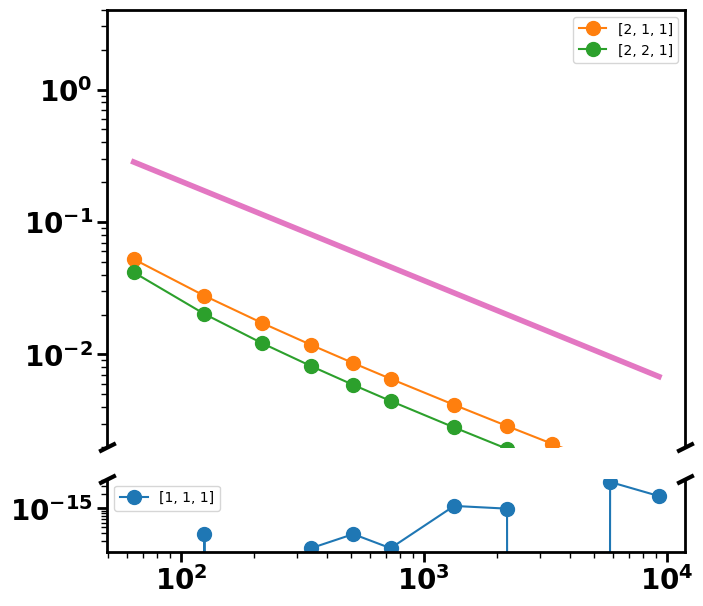

In [165]:
x = edata.V_nums
y = np.array(list(edata.relative_eigenvalue_differences.values())).T
plot_loglog_rel_err(x, y, show_legend=True, rate_scaling=1, rate_slope=3 / 4)
# plt.savefig("tiling/cubic_clamped/cubic_clamped_tiling_eigenvalue_relerr.png", dpi=200, bbox_inches='tight')

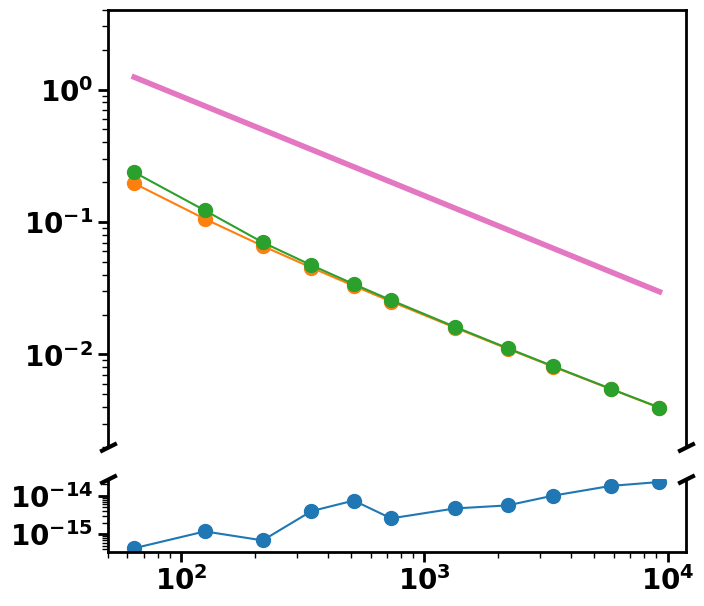

In [164]:
x = edata.V_nums
y = np.array(list(edata.relative_eigenfunction_differences.values())).T
plot_loglog_rel_err(x, y, show_legend=False, rate_scaling=1, rate_slope=3/4)
# plt.savefig("tiling/cubic_clamped/cubic_clamped_tiling_eigenfunction_relerr.png", dpi=200, bbox_inches='tight')

In [18]:
g = Stacked_Lattice(tiles_per_dim[4], autoplot=False)
g.num_Vs

512

In [49]:
plot_and_save_modes = True

In [50]:
if plot_and_save_modes:

    g = Stacked_Lattice(tiles_per_dim[4], autoplot=False)
    print(g.num_Vs)

    for m0, m1, m2 in ms:
        print(m0, m1, m2)
        emodes = full_data[g.num_Vs][m0, m1, m2]['graph']['eigenfunction']
        for en, emode in enumerate(emodes):
            print(en)
            fig, ax = g.plot_graph(eigenmode=emode.data, return_figax=True, 
                                   background_color="black", dim=3)
            ax.set_facecolor("black")
            fac=0.1
            ax.set_xlim(fac, 1-fac)
            ax.set_ylim(fac, 1-fac)
            ax.set_zlim(fac*0.8, 1-fac*1.2)
            plt.savefig(f"tiling/cubic_clamped/mode_plots/eigenmode_{g.num_Vs}Vs_ms{m0}_{m1}_{m2}_number{en}.png", dpi=200, bbox_inches='tight')
            plt.close()
        print()

plot_and_save_modes = False

512
1 1 1
0

2 1 1
0
1
2

2 2 1
0
1
2



In [199]:
plot_and_save_continuum_modes = True

In [200]:
N = 100  # Number of points in each dimension
# Create a 3D grid of points
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
z = np.linspace(0, 1, N)
x, y, z = np.meshgrid(x, y, z)
x = x.flatten()
y = y.flatten()
z = z.flatten()
mask = ~((x > 0.25) & (y > 0.25) & (z > 0.25))

if plot_and_save_continuum_modes:

    for m0, m1, m2 in ms:
        print(m0, m1, m2)
        funcs = Continuum_Eigendata("clamped_square_cube").generate_basis_functions((m0, m1, m2))
        for en, func in enumerate(funcs):
            print(en)
            fun = func(x[mask], y[mask], z[mask]).flatten()
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(x[mask], y[mask], z[mask], c=fun, s=50, cmap='plasma')
            ax.view_init(15, 15)
            style_plot(fig, ax, aspect="equal", no_ticks=True)
            ax.axis('off')
            fac=0.1
            ax.set_xlim(fac, 1-fac)
            ax.set_ylim(fac, 1-fac)
            ax.set_zlim(fac*0.8, 1-fac*1.2)
            fig.set_facecolor("black")
            ax.set_facecolor("black")
            plt.savefig(f"tiling/cubic_clamped/PDE_mode_plots/continuum_eigenmode_ms{m0}_{m1}_{m2}_number{en}.png", dpi=200, bbox_inches='tight')
            plt.close()
        print()

plot_and_save_continuum_modes = False

1 1 1
0

2 1 1
0
1
2

2 2 1
0
1
2



In [194]:
ms

[[1, 1, 1], [2, 1, 1], [2, 2, 1]]